In [1]:
import matplotlib as mpl, hashlib, rapids_singlecell as rsc, cupy as cp, gc, re
cmap = mpl.colormaps['tab20']
import pandas as pd, matplotlib.pyplot as plt, seaborn as sns, scanpy as sc, numpy as np, os
from collections import defaultdict
from anndata import AnnData
from scipy.stats import linregress, pearsonr
from matplotlib.colors import LogNorm, LinearSegmentedColormap, PowerNorm, ListedColormap, FuncNorm
import matplotlib.patches as mpatches
from mpl_toolkits.axes_grid1 import make_axes_locatable
from utils import load_model_state, predict

In [2]:
rna_dir = "analysis/result/DNN_v3_torch/"
atac_dir = "atac_analysis_astro/result/DNN_v3_torch/"

In [4]:
def seed_all(seed=42):
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
seed_all(42)

### Get avg. proba. for each cell for both modalities

In [5]:
adata_rna = sc.read_h5ad("analysis/result/aci_dims1to10_06_19_25_type_anno_precomp_v3.h5ad")

In [6]:
adata_atac = sc.read_h5ad("atac_analysis_astro/result/aci_raw_ATAC_filtered_v2_precomp_v3.h5ad")

In [7]:
common_barcodes = adata_rna.obs_names.intersection(adata_atac.obs_names)

In [8]:
adata_rna._inplace_subset_obs(common_barcodes)
adata_atac._inplace_subset_obs(common_barcodes)

In [9]:
adata_rna

AnnData object with n_obs × n_vars = 19415 × 13964
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'percent.mito', 'percent.ribo', 'percent.hemo', 'doublet.filter', 'Jorstard.pred', 'harmony_clusters', 'seurat_clusters', 'remove_or_not', 'unintegrated_clusters', 'AD', 'Subclass', 'Subclass_fct', 'class', 'brain.region', 'Louvain_2', 'SLM', 'optm_clusters', 'Leiden', 'tp_mkr_1', 'tp_mkr_2', 'tp_mkr_3', 'tp_mkr_4', 'tp_mkr_5', 'tp_mkr_6', 'tp_mkr_7', 'tp_mkr_8', 'tp_mkr_9', 'tp_mkr_10', 'tp_mkr_11', 'tp_mkr_12', 'tp_mkr_13', 'tp_mkr_14', 'tp_mkr_15', 'tp_mkr_16', 'tp_mkr_17', 'tp_mkr_18', 'A1_reactive1', 'Mature_astrocyte2', 'Progenitor_marker3', 'Reactive_microglia4', 'Scar_forming5', 'Tripartite_synapse6', 'celltype', 'n_counts', 'n_genes'
    var: 'n_counts', 'n_cells'
    uns: 'log1p', 'pca'
    obsm: 'X_pca'
    varm: 'PCs'

In [10]:
adata_atac

AnnData object with n_obs × n_vars = 19415 × 151956
    obs: 'orig.ident', 'nCount_atac', 'nFeature_atac', 'brain.region', 'AD', 'n_counts', 'n_genes'
    var: 'n_cells', 'n_counts'
    uns: 'log1p', 'pca'
    obsm: 'X_pca'
    varm: 'PCs'

In [11]:
rna_param_df = pd.read_csv(os.path.join(rna_dir,"fold_auroc.csv"))
# rna_selections = (rna_param_df["AUROC"] > 0.7)
# rna_flip_mask  = (rna_param_df["Raw_AUROC"] < 0.5)
# rna_flip_flags = np.array([bool(rna_flip_mask[i]) for i, k in enumerate(rna_selections) if k], dtype = bool)[:, None]  # aligned to kept_paths

In [12]:
# rna_flip_flags.shape

In [13]:
atac_param_df = pd.read_csv(os.path.join(atac_dir,"fold_auroc.csv"))
# atac_selections = (atac_param_df["AUROC"] > 0.7).tolist()
# atac_flip_mask  = (atac_param_df["Raw_AUROC"] < 0.5)
# atac_flip_flags = np.array([bool(atac_flip_mask[i]) for i, k in enumerate(atac_selections) if k], dtype = bool)[:, None]  # aligned to kept_paths

In [16]:
# Models are formatted the same for both modalities
model_dir = f"{rna_dir}models/"
model_paths = os.listdir(model_dir)
def fold_num(name: str) -> int:
    return int(re.search(r"fold(\d+)_", name).group(1))

mp_sorted = sorted(model_paths, key=fold_num)

In [18]:
rna_model_dir = os.path.join(rna_dir, "models/")
atac_model_dir = os.path.join(atac_dir, "models/")

In [19]:
rna_models = [load_model_state(rna_model_dir + mp, input_dim = adata_rna.obsm["X_pca"].shape[1]) for mp in mp_sorted]
atac_models = [load_model_state(atac_model_dir + mp, input_dim = adata_atac.obsm["X_pca"].shape[1]) for mp in mp_sorted]

In [20]:
def hard_labels_and_median_proba(adata, auroc_df, models, obsm_key="X_pca", donor_col="orig.ident"):
    X = adata.obsm[obsm_key]
    donors = adata.obs[donor_col].to_numpy()

    # parse per-fold pairs and thresholds
    pairs = (
        auroc_df["test_pair"]
        .astype(str)
        .str.extract(r"\[\s*(-?\d+)\s*,\s*(-?\d+)\s*\]")
        .astype(int)
        .to_numpy()  # (n_folds, 2)
    )
    folds = auroc_df["Fold"].to_numpy(int)
    thr_map = dict(zip(folds, auroc_df["threshold"].astype(float)))

    # donor -> folds containing that donor
    d2f = defaultdict(list)
    for f, (a, b) in zip(folds, pairs):
        d2f[a].append(f); d2f[b].append(f)

    y_out    = np.zeros(X.shape[0], dtype=np.uint8)       # final hard labels
    pmed_out = np.full(X.shape[0], np.nan, dtype=float)   # median probs

    for d in pd.unique(donors):
        idx = np.flatnonzero(donors == d)
        fs  = d2f.get(d, [])
        if not fs or idx.size == 0:
            continue

        # probs from each relevant model for this donor's cells
        P = np.column_stack([predict(models[f], X[idx]).squeeze() for f in fs])  # (cells_donor, n_models)
        p_med = np.median(P, axis=1)
        pmed_out[idx] = p_med

        # per-model hard calls using each model's own threshold
        B = np.column_stack([(P[:, j] >= thr_map[fs[j]]).astype(np.uint8) for j in range(len(fs))])
        y_out[idx] = (B.mean(axis=1) >= 0.5).astype(np.uint8)  # majority vote

    return y_out, pmed_out  # (N,), (N,)

In [21]:
labels_rna, avg_rna = hard_labels_and_median_proba(adata_rna, rna_param_df, rna_models)

In [22]:
avg_rna.shape

(19415,)

In [23]:
avg_rna

array([2.65597785e-03, 7.49153401e-07, 9.06275958e-02, ...,
       1.12823313e-04, 3.13508295e-08, 2.46597394e-01], shape=(19415,))

In [24]:
labels_atac, avg_atac = hard_labels_and_median_proba(adata_atac, atac_param_df, atac_models)

In [25]:
# for i, model in enumerate(atac_models):
#     proba_atac[i] = model.predict(adata_atac.obsm["X_pca"], verbose = 0).squeeze()
# proba_atac = np.where(atac_flip_flags, 1 - proba_atac, proba_atac)
# avg_atac = np.mean(proba_atac, axis = 0)

In [26]:
avg_atac.shape

(19415,)

In [27]:
avg_atac

array([0.00233897, 0.00062276, 0.02981637, ..., 0.0007564 , 0.00154067,
       0.00021347], shape=(19415,))

In [28]:
avg_proba_df = pd.DataFrame({"barcodes": adata_rna.obs_names, "rna_avg_proba": avg_rna, "atac_avg_proba": avg_atac})

In [29]:
avg_proba_df.head()

,barcodes,rna_avg_proba,atac_avg_proba
0,BA9_2012_AAAGCTTGTGCAACTA-1,2.655978e-03,0.002339
1,BA9_2012_AACCTTAAGCTCCCTG-1,7.491534e-07,0.000623
2,BA9_2012_AAGTTAGCAATAAGCA-1,9.062760e-02,0.029816
3,BA9_2012_AATGCAACAAACTGTT-1,3.263956e-03,0.023924
4,BA9_2012_AATTGACGTTGCGCGA-1,8.781580e-05,0.048945


In [71]:
avg_proba_df.to_csv("joint_analysis_non_multiome/single_cell_avg_proba_torch.csv", index = False)

### Density plots

In [68]:
def plot_ad_vs_control_density_emphasize_high(avg_rna, avg_atac, adata,
                                              gridsize=70, gamma=2.0, max_count=None):
    """
    Two hexbins (Control vs AD) with shared PowerNorm (gamma>1) to emphasize large counts.
    Cap the color scale at `max_count` so bins above it take the max color.
    Legend and r-value are placed OUTSIDE the plotting area.
    """
    import numpy as np
    import matplotlib as mpl
    import matplotlib.pyplot as plt
    from scipy.stats import linregress
    from mpl_toolkits.axes_grid1 import make_axes_locatable

    if "AD" not in adata.obs:
        raise KeyError("adata.obs['AD'] not found (expected values 'AD'/'Control').")

    x = np.asarray(avg_rna); y = np.asarray(avg_atac)
    if x.shape != y.shape: raise ValueError("avg_rna and avg_atac must have the same shape.")
    if len(x) != adata.n_obs: raise ValueError("Lengths of avg_* must match adata.n_obs.")

    labels = adata.obs["AD"].astype(str).to_numpy()
    m_ctrl = labels == "Control"
    m_ad   = labels == "AD"

    ok = np.isfinite(x) & np.isfinite(y)
    x, y, m_ctrl, m_ad = x[ok], y[ok], m_ctrl[ok], m_ad[ok]
    extent = [x.min(), x.max(), y.min(), y.max()]

    fig, ax = plt.subplots(figsize=(10, 8))

    hb_ctrl = ax.hexbin(x[m_ctrl], y[m_ctrl], gridsize=gridsize, extent=extent,
                        mincnt=1, cmap="Blues", alpha=0.85, linewidths=0, zorder=1)
    hb_ad   = ax.hexbin(x[m_ad],   y[m_ad],   gridsize=gridsize, extent=extent,
                        mincnt=1, cmap="Reds",  alpha=0.85, linewidths=0, zorder=2)

    # Shared non-linear scale with optional cap (mask-safe)
    arr_all = np.ma.concatenate([np.ma.array(hb_ctrl.get_array()),
                                 np.ma.array(hb_ad.get_array())]).compressed()
    if arr_all.size == 0:
        vmin_data, vmax_data = 0.0, 1.0
    else:
        vmin_data, vmax_data = float(arr_all.min()), float(arr_all.max())
        if not np.isfinite(vmin_data): vmin_data = 0.0
        if not np.isfinite(vmax_data): vmax_data = max(vmin_data + 1.0, 1.0)

    vmax_eff = vmax_data
    if max_count is not None and np.isfinite(max_count):
        vmax_eff = max(float(max_count), vmin_data + 1e-9)  # ensure positive range

    norm = mpl.colors.PowerNorm(gamma=gamma, vmin=vmin_data, vmax=vmax_eff)
    hb_ctrl.set_norm(norm); hb_ad.set_norm(norm)

    # Best-fit + diagonal
    res = linregress(x, y)
    xx = np.linspace(x.min(), x.max(), 200)
    ax.plot(xx, res.slope*xx + res.intercept, lw=2, c="red", alpha=0.7, label="best_fit")
    lo, hi = min(x.min(), y.min()), max(x.max(), y.max())
    ax.plot([lo, hi], [lo, hi], ls="--", lw=1, c="orange", alpha=0.9, label="diagonal")

    ax.set_xlabel("Average probability of being AD from RNA")
    ax.set_ylabel("Average probability of being AD from ATAC")
    ax.set_title(f"Density of AD vs Control (PowerNorm γ={gamma}"
                 f"{', cap='+str(int(vmax_eff)) if max_count is not None else ''})")

    # --- Place r OUTSIDE the axes (top-left margin) ---
    # Use the current subplot margins so the text sits nicely in the figure margin.
    fig.subplots_adjust(right=0.80, top=0.90, bottom=0.20)  # room for colorbars/top text/bottom legend
    fig.text(fig.subplotpars.left, 0.96, f"r = {res.rvalue:.3f}",
             ha="left", va="top", fontsize=10)

    # --- Two right-side colorbars (shared scale) ---
    divider = make_axes_locatable(ax)
    cb_ctrl = fig.colorbar(hb_ctrl, cax=divider.append_axes("right", size="3%", pad=0.12))
    cb_ad   = fig.colorbar(hb_ad,   cax=divider.append_axes("right", size="3%", pad=0.50))
    cb_ctrl.set_label("Control density", color="#1f77b4", labelpad=6)
    cb_ad.set_label("AD density", color="#d62728", labelpad=6)
    for cb, color in [(cb_ctrl, "#1f77b4"), (cb_ad, "#d62728")]:
        cb.ax.yaxis.set_ticks_position('right')
        cb.ax.yaxis.set_label_position('right')
        cb.ax.tick_params(labelsize=9, pad=2, colors=color)
        cb.ax.minorticks_off()

    # --- Move legend OUTSIDE (below the axes) ---
    ax.legend(loc="upper center", bbox_to_anchor=(0.5, -0.12), ncol=2, frameon=False)

    return fig, ax, (cb_ctrl, cb_ad)

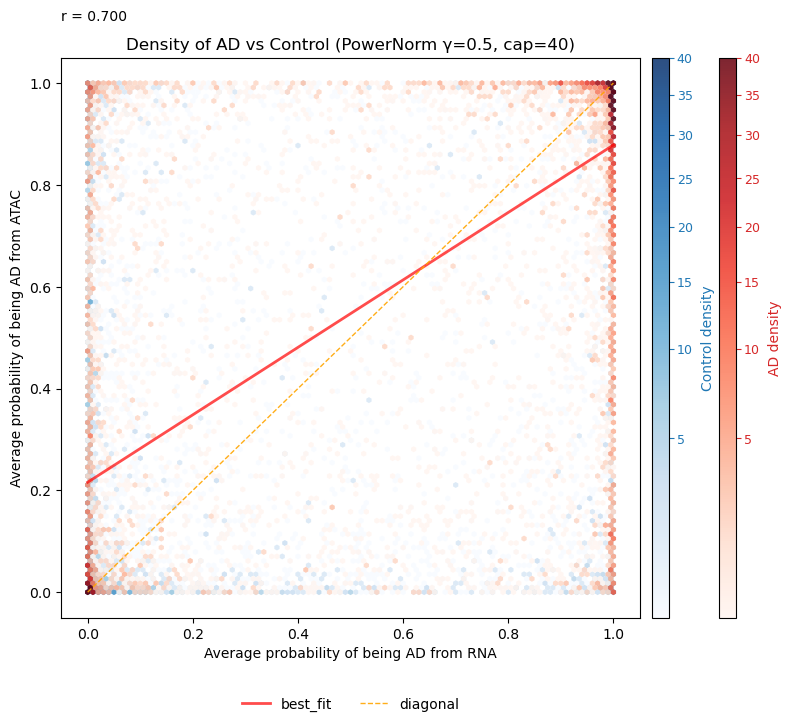

In [70]:
# cap at 50 counts; bins > 50 take the top color
fig, ax, _ = plot_ad_vs_control_density_emphasize_high(avg_rna, avg_atac, adata_rna, gridsize = 100, gamma=0.5, max_count=40)
plt.show()

# no cap (uses data max)
# fig, ax, _ = plot_ad_vs_control_density_emphasize_high(avg_rna, avg_atac, adata_rna,
#                                                        gamma=2.5, max_count=None)
# plt.show()

In [72]:
import numpy as np, pandas as pd
from scipy.stats import pearsonr
rng = np.random.default_rng(0)

p_rna  = np.asarray(avg_rna)
p_atac = np.asarray(avg_atac)

obs_r, _ = pearsonr(p_rna, p_atac)
perm = [pearsonr(rng.permutation(p_rna), p_atac)[0] for _ in range(1000)]
pval = (np.sum(np.abs(perm) >= abs(obs_r)) + 1) / (len(perm) + 1)

In [73]:
pval

np.float64(0.000999000999000999)

In [76]:
meta = adata_rna.obs[["orig.ident","brain.region"]]
df = meta.assign(p_rna=p_rna, p_atac=p_atac).groupby(["orig.ident","brain.region"], observed = True).mean()
r_bulk = df["p_rna"].corr(df["p_atac"])

In [77]:
r_bulk

np.float64(0.9498170597238013)

In [78]:
df

p_rna    p_atac
orig.ident brain.region                    
2012       BA9           0.058702  0.125678
           BA17          0.004864  0.125631
           BA20          0.140865  0.125736
2021       BA9           0.999761  0.997656
           BA17          0.023671  0.094379
           BA20          0.999771  0.996556
2026       BA9           0.953594  0.857753
           BA17          0.964241  0.722546
           BA20          0.992065  0.935800
2027       BA9           0.463905  0.632245
2037       BA9           0.994361  0.988180
           BA17          0.999861  0.989810
           BA20          0.999981  0.996480
2057       BA9           0.324282  0.437285
           BA17          0.395900  0.571710
           BA20          0.488745  0.720667
2058       BA9           0.367716  0.355836
           BA17          0.456739  0.533570
           BA20          0.409916  0.500285
2068       BA9           0.047923  0.118897
           BA17          0.059798  0.259069
           BA20          0.077500  0.234998
2097       BA9           0.269965  0.221426
           BA17          0.274147  0.694835
           BA20          0.384128  0.416075
2112       BA9           0.991852  0.995799
           BA17          0.996069  0.990641
           BA20          0.999932  0.994237
2178       BA17          0.982934  0.895785
           BA20          0.985101  0.991070
2191       BA9           0.159326  0.123277
           BA17          0.504263  0.372926
           BA20          0.281849  0.363019
2210       BA9           0.760642  0.686752
           BA17          0.860839  0.791860
           BA20          0.701620  0.710466
2232       BA9           0.999446  0.998658
           BA17          0.999845  0.968880
           BA20          0.999840  0.998506
2259       BA17          0.170426  0.017159
2274       BA9           0.145389  0.273144
           BA17          0.236305  0.310940
           BA20          0.214936  0.103955
2327       BA9           0.008985  0.061255
           BA17          0.045718  0.400295
           BA20          0.003270  0.253830
2339       BA9           0.926034  0.701491
           BA17          0.989579  0.970093
           BA20          0.650101  0.517251
2380       BA9           0.009274  0.001931
           BA17          0.021090  0.006128
           BA20          0.009801  0.053650

In [79]:
def plot_pseudobulk_df(df, title="Pseudobulk RNA vs ATAC agreement"):
    """
    Expects df with columns: 'p_rna', 'p_atac'.
    Returns: fig, ax, stats dict
    """
    import numpy as np
    import matplotlib.pyplot as plt
    from scipy.stats import linregress, pearsonr, spearmanr

    x = np.asarray(df["p_rna"].values, dtype=float)
    y = np.asarray(df["p_atac"].values, dtype=float)
    m = np.isfinite(x) & np.isfinite(y)
    x, y = x[m], y[m]
    if x.size < 2:
        raise ValueError("Need at least 2 points to compute correlation/fit.")

    # Stats
    pr, p_p = pearsonr(x, y)
    sr, s_p = spearmanr(x, y)
    fit = linregress(x, y)

    # Plot
    fig, ax = plt.subplots(figsize=(5.5, 5))
    ax.scatter(x, y, s=28, alpha=0.8)

    xx = np.linspace(x.min(), x.max(), 200)
    ax.plot(xx, fit.slope * xx + fit.intercept, lw=2, alpha=0.9, label="best_fit")
    lo, hi = min(x.min(), y.min()), max(x.max(), y.max())
    ax.plot([lo, hi], [lo, hi], ls="--", lw=1, alpha=0.9, label="diagonal")

    ax.set_xlabel("Pseudobulk AD probability (RNA)")
    ax.set_ylabel("Pseudobulk AD probability (ATAC)")
    ax.set_title(title)

    # Put stats OUTSIDE the axes (top-left margin), legend below plot
    fig.subplots_adjust(top=0.90, bottom=0.20, right=0.98)
    fig.text(fig.subplotpars.left, 0.965,
             f"Pearson r = {pr:.3f} (p={p_p:.1e}) | Spearman ρ = {sr:.3f} (p={s_p:.1e})",
             ha="left", va="top", fontsize=10)
    ax.legend(loc="upper center", bbox_to_anchor=(0.5, -0.12), ncol=2, frameon=False)

    return fig, ax, {"pearson_r": pr, "pearson_p": p_p, "spearman_rho": sr, "spearman_p": s_p}

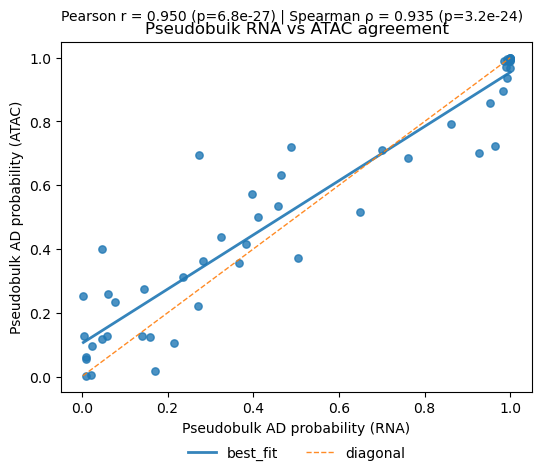

In [80]:
fig, ax, data = plot_pseudobulk_df(df)

### Downsample or not feature importance

In [2]:
orig_imp = pd.read_csv("result/astro/atac/common_peak_importance.csv")
down_imp = pd.read_csv("result/astro/atac/downsampled_microglia/common_peak_importance.csv")

In [3]:
orig_imp.head()

,Peak,frac_imp
0,chr1-16913821-16914320,0.087010
1,chr10-132537302-132537801,0.076784
2,chr4-37686273-37686772,0.066093
3,chr11-44565157-44565656,0.061188
4,chr9-93095805-93096304,0.059871


In [4]:
down_imp.head()

,Peak,frac_imp
0,chr1-16913821-16914320,0.090526
1,chr10-132537302-132537801,0.076708
2,chr4-37686273-37686772,0.067731
3,chr11-44565157-44565656,0.063225
4,chr9-93095805-93096304,0.062546


In [5]:
orig_imp.shape

(143709, 2)

In [6]:
down_imp.shape

(143709, 2)

Pearson r=0.999, p=0.0e+00


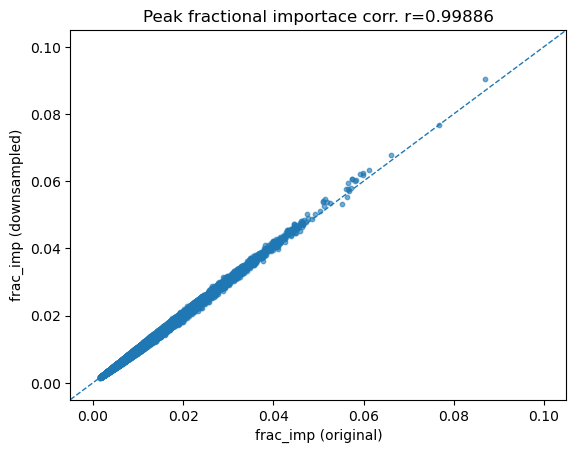

In [10]:
# align by Gene (order-agnostic)
g = orig_imp["Peak"].astype(str)
x = orig_imp.set_index(g)["frac_imp"]
y = down_imp.set_index(down_imp["Peak"].astype(str)).reindex(g)["frac_imp"]

# Pearson + scatter
r, p = pearsonr(x, y); print(f"Pearson r={r:.3f}, p={p:.1e}")
plt.scatter(x, y, s=10, alpha=0.6)
plt.xlabel("frac_imp (original)"); plt.ylabel("frac_imp (downsampled)")
plt.title(f"Peak fractional importace corr. r={r:.5f}")
plt.axline((0,0),(0.1,0.1), linestyle="--", linewidth=1); plt.show()